# Packages

In [1]:
! pip install numba 

Defaulting to user installation because normal site-packages is not writeable


In [2]:
pip install scikit-learn shap

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
import time

import numba
import numpy as np
import sklearn.ensemble

import shap

/home/onyxia/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
import matplotlib.pyplot as plt
from sksurv.datasets import load_whas500
from sksurv.ensemble import RandomSurvivalForest
from sklearn.model_selection import train_test_split
from lifelines import KaplanMeierFitter
import numpy as np
import itertools
import random

# Fonction

In [4]:
#au t-ième moment 

class TreeExplainer:
    def __init__(self, model, t=0, **kwargs):
        if str(type(model)).endswith("sklearn.ensemble._forest.RandomForestRegressor'>") or 1==1: #attention
            # self.trees = [Tree(e.tree_) for e in model.estimators_]
            self.trees = [
                Tree(
                    children_left=e.tree_.children_left,
                    children_right=e.tree_.children_right,
                    children_default=e.tree_.children_right,
                    feature=e.tree_.feature,
                    threshold=e.tree_.threshold,
                    value=e.tree_.value[:, t, 1],
                    node_sample_weight=e.tree_.weighted_n_node_samples,
                )
                for e in model.estimators_
            ]

        # Preallocate space for the unique path data
        maxd = np.max([t.max_depth for t in self.trees]) + 2
        s = (maxd * (maxd + 1)) // 2
        self.feature_indexes = np.zeros(s, dtype=np.int32)
        self.zero_fractions = np.zeros(s, dtype=np.float64)
        self.one_fractions = np.zeros(s, dtype=np.float64)
        self.pweights = np.zeros(s, dtype=np.float64)

    def shap_values(self, X, **kwargs):
        # convert dataframes
        if str(type(X)).endswith("pandas.core.series.Series'>"):
            X = X.values
        elif str(type(X)).endswith("'pandas.core.frame.DataFrame'>"):
            X = X.values

        assert str(type(X)).endswith("'numpy.ndarray'>"), "Unknown instance type: " + str(type(X))
        assert len(X.shape) == 1 or len(X.shape) == 2, "Instance must have 1 or 2 dimensions!"

        # single instance
        if len(X.shape) == 1:
            phi = np.zeros(X.shape[0] + 1)
            x_missing = np.zeros(X.shape[0], dtype=bool)
            for t in self.trees:
                self.tree_shap(t, X, x_missing, phi)
            phi /= len(self.trees)
        elif len(X.shape) == 2:
            phi = np.zeros((X.shape[0], X.shape[1] + 1))
            x_missing = np.zeros(X.shape[1], dtype=bool)
            for i in range(X.shape[0]):
                for t in self.trees:
                    self.tree_shap(t, X[i, :], x_missing, phi[i, :])
            phi /= len(self.trees)
        return phi

    def tree_shap(self, tree, x, x_missing, phi, condition=0, condition_feature=0):
        # update the bias term, which is the last index in phi
        # (note the paper has this as phi_0 instead of phi_M)
        if condition == 0:
            phi[-1] += tree.values[0]

        # start the recursive algorithm
        tree_shap_recursive(
            tree.children_left,
            tree.children_right,
            tree.children_default,
            tree.features,
            tree.thresholds,
            tree.values,
            tree.node_sample_weight,
            x,
            x_missing,
            phi,
            0,
            0,
            self.feature_indexes,
            self.zero_fractions,
            self.one_fractions,
            self.pweights,
            1,
            1,
            -1,
            condition,
            condition_feature,
            1,
        )

In [5]:
# extend our decision path with a fraction of one and zero extensions
@numba.jit(
    numba.types.void(
        numba.types.int32[:],
        numba.types.float64[:],
        numba.types.float64[:],
        numba.types.float64[:],
        numba.types.int32,
        numba.types.float64,
        numba.types.float64,
        numba.types.int32,
    ),
    nopython=True,
    nogil=True,
)
def extend_path(
    feature_indexes,
    zero_fractions,
    one_fractions,
    pweights,
    unique_depth,
    zero_fraction,
    one_fraction,
    feature_index,
):
    feature_indexes[unique_depth] = feature_index
    zero_fractions[unique_depth] = zero_fraction
    one_fractions[unique_depth] = one_fraction
    if unique_depth == 0:
        pweights[unique_depth] = 1
    else:
        pweights[unique_depth] = 0

    for i in range(unique_depth - 1, -1, -1):
        pweights[i + 1] += one_fraction * pweights[i] * (i + 1) / (unique_depth + 1)
        pweights[i] = zero_fraction * pweights[i] * (unique_depth - i) / (unique_depth + 1)


# undo a previous extension of the decision path
@numba.jit(
    numba.types.void(
        numba.types.int32[:],
        numba.types.float64[:],
        numba.types.float64[:],
        numba.types.float64[:],
        numba.types.int32,
        numba.types.int32,
    ),
    nopython=True,
    nogil=True,
)
def unwind_path(feature_indexes, zero_fractions, one_fractions, pweights, unique_depth, path_index):
    one_fraction = one_fractions[path_index]
    zero_fraction = zero_fractions[path_index]
    next_one_portion = pweights[unique_depth]

    for i in range(unique_depth - 1, -1, -1):
        if one_fraction != 0:
            tmp = pweights[i]
            pweights[i] = next_one_portion * (unique_depth + 1) / ((i + 1) * one_fraction)
            next_one_portion = tmp - pweights[i] * zero_fraction * (unique_depth - i) / (unique_depth + 1)
        else:
            pweights[i] = (pweights[i] * (unique_depth + 1)) / (zero_fraction * (unique_depth - i))

    for i in range(path_index, unique_depth):
        feature_indexes[i] = feature_indexes[i + 1]
        zero_fractions[i] = zero_fractions[i + 1]
        one_fractions[i] = one_fractions[i + 1]


# determine what the total permuation weight would be if
# we unwound a previous extension in the decision path
@numba.jit(
    numba.types.float64(
        numba.types.int32[:],
        numba.types.float64[:],
        numba.types.float64[:],
        numba.types.float64[:],
        numba.types.int32,
        numba.types.int32,
    ),
    nopython=True,
    nogil=True,
)
def unwound_path_sum(feature_indexes, zero_fractions, one_fractions, pweights, unique_depth, path_index):
    one_fraction = one_fractions[path_index]
    zero_fraction = zero_fractions[path_index]
    next_one_portion = pweights[unique_depth]
    total = 0

    for i in range(unique_depth - 1, -1, -1):
        if one_fraction != 0:
            tmp = next_one_portion * (unique_depth + 1) / ((i + 1) * one_fraction)
            total += tmp
            next_one_portion = pweights[i] - tmp * zero_fraction * ((unique_depth - i) / (unique_depth + 1))
        else:
            total += (pweights[i] / zero_fraction) / ((unique_depth - i) / (unique_depth + 1))

    return total


class Tree:
    def __init__(
        self,
        children_left,
        children_right,
        children_default,
        feature,
        threshold,
        value,
        node_sample_weight,
    ):
        self.children_left = children_left.astype(np.int32)
        self.children_right = children_right.astype(np.int32)
        self.children_default = children_default.astype(np.int32)
        self.features = feature.astype(np.int32)
        self.thresholds = threshold
        self.values = value
        self.node_sample_weight = node_sample_weight

        self.max_depth = compute_expectations(
            self.children_left,
            self.children_right,
            self.node_sample_weight,
            self.values,
            0,
        )


@numba.jit(nopython=True)
def compute_expectations(children_left, children_right, node_sample_weight, values, i, depth=0):
    if children_right[i] == -1:
        values[i] = values[i]
        return 0
    else:
        li = children_left[i]
        ri = children_right[i]
        depth_left = compute_expectations(children_left, children_right, node_sample_weight, values, li, depth + 1)
        depth_right = compute_expectations(children_left, children_right, node_sample_weight, values, ri, depth + 1)
        left_weight = node_sample_weight[li]
        right_weight = node_sample_weight[ri]
        v = (left_weight * values[li] + right_weight * values[ri]) / (left_weight + right_weight)
        values[i] = v
        return max(depth_left, depth_right) + 1


# recursive computation of SHAP values for a decision tree
@numba.jit(
    numba.types.void(
        numba.types.int32[:],
        numba.types.int32[:],
        numba.types.int32[:],
        numba.types.int32[:],
        numba.types.float64[:],
        numba.types.float64[:],
        numba.types.float64[:],
        numba.types.float64[:],
        numba.types.boolean[:],
        numba.types.float64[:],
        numba.types.int64,
        numba.types.int64,
        numba.types.int32[:],
        numba.types.float64[:],
        numba.types.float64[:],
        numba.types.float64[:],
        numba.types.float64,
        numba.types.float64,
        numba.types.int64,
        numba.types.int64,
        numba.types.int64,
        numba.types.float64,
    ),
    nopython=True,
    nogil=True,
)
def tree_shap_recursive(
    children_left,
    children_right,
    children_default,
    features,
    thresholds,
    values,
    node_sample_weight,
    x,
    x_missing,
    phi,
    node_index,
    unique_depth,
    parent_feature_indexes,
    parent_zero_fractions,
    parent_one_fractions,
    parent_pweights,
    parent_zero_fraction,
    parent_one_fraction,
    parent_feature_index,
    condition,
    condition_feature,
    condition_fraction,
):
    # stop if we have no weight coming down to us
    if condition_fraction == 0:
        return

    # extend the unique path
    feature_indexes = parent_feature_indexes[unique_depth + 1 :]
    feature_indexes[: unique_depth + 1] = parent_feature_indexes[: unique_depth + 1]
    zero_fractions = parent_zero_fractions[unique_depth + 1 :]
    zero_fractions[: unique_depth + 1] = parent_zero_fractions[: unique_depth + 1]
    one_fractions = parent_one_fractions[unique_depth + 1 :]
    one_fractions[: unique_depth + 1] = parent_one_fractions[: unique_depth + 1]
    pweights = parent_pweights[unique_depth + 1 :]
    pweights[: unique_depth + 1] = parent_pweights[: unique_depth + 1]

    if condition == 0 or condition_feature != parent_feature_index:
        extend_path(
            feature_indexes,
            zero_fractions,
            one_fractions,
            pweights,
            unique_depth,
            parent_zero_fraction,
            parent_one_fraction,
            parent_feature_index,
        )

    split_index = features[node_index]

    # leaf node
    if children_right[node_index] == -1:
        for i in range(1, unique_depth + 1):
            w = unwound_path_sum(
                feature_indexes,
                zero_fractions,
                one_fractions,
                pweights,
                unique_depth,
                i,
            )
            phi[feature_indexes[i]] += (
                w * (one_fractions[i] - zero_fractions[i]) * values[node_index] * condition_fraction
            )

    # internal node
    else:
        # find which branch is "hot" (meaning x would follow it)
        hot_index = 0
        cleft = children_left[node_index]
        cright = children_right[node_index]
        if x_missing[split_index] == 1:
            hot_index = children_default[node_index]
        elif x[split_index] < thresholds[node_index]:
            hot_index = cleft
        else:
            hot_index = cright
        cold_index = cright if hot_index == cleft else cleft
        w = node_sample_weight[node_index]
        hot_zero_fraction = node_sample_weight[hot_index] / w
        cold_zero_fraction = node_sample_weight[cold_index] / w
        incoming_zero_fraction = 1
        incoming_one_fraction = 1

        # see if we have already split on this feature,
        # if so we undo that split so we can redo it for this node
        path_index = 0
        while path_index <= unique_depth:
            if feature_indexes[path_index] == split_index:
                break
            path_index += 1

        if path_index != unique_depth + 1:
            incoming_zero_fraction = zero_fractions[path_index]
            incoming_one_fraction = one_fractions[path_index]
            unwind_path(
                feature_indexes,
                zero_fractions,
                one_fractions,
                pweights,
                unique_depth,
                path_index,
            )
            unique_depth -= 1

        # divide up the condition_fraction among the recursive calls
        hot_condition_fraction = condition_fraction
        cold_condition_fraction = condition_fraction
        if condition > 0 and split_index == condition_feature:
            cold_condition_fraction = 0
            unique_depth -= 1
        elif condition < 0 and split_index == condition_feature:
            hot_condition_fraction *= hot_zero_fraction
            cold_condition_fraction *= cold_zero_fraction
            unique_depth -= 1

        tree_shap_recursive(
            children_left,
            children_right,
            children_default,
            features,
            thresholds,
            values,
            node_sample_weight,
            x,
            x_missing,
            phi,
            hot_index,
            unique_depth + 1,
            feature_indexes,
            zero_fractions,
            one_fractions,
            pweights,
            hot_zero_fraction * incoming_zero_fraction,
            incoming_one_fraction,
            split_index,
            condition,
            condition_feature,
            hot_condition_fraction,
        )

        tree_shap_recursive(
            children_left,
            children_right,
            children_default,
            features,
            thresholds,
            values,
            node_sample_weight,
            x,
            x_missing,
            phi,
            cold_index,
            unique_depth + 1,
            feature_indexes,
            zero_fractions,
            one_fractions,
            pweights,
            cold_zero_fraction * incoming_zero_fraction,
            0,
            split_index,
            condition,
            condition_feature,
            cold_condition_fraction,
        )

# RSF

In [12]:
X, y = load_whas500()
X = X.astype(float)
X = X.iloc[:, :3]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
rsf = RandomSurvivalForest(random_state=42).fit(X_train, y_train)

# Comparaison

In [14]:
ex = TreeExplainer(rsf)

In [29]:
ex.shap_values(X_test.iloc[0, :])

array([0.00162818, 0.01387918, 0.00185424, 0.982125  ])

In [16]:
X_test.iloc[1, :]

afb     0.0
age    77.0
av3     0.0
Name: 73, dtype: float64

In [17]:
from survinsights import local_explaination
from survinsights.explainer import explainer
eval_times = list(range(1,200,10))
model_explainer = explainer(rsf, X_test, y_test, 
                             times=eval_times)

In [50]:
SurvSHAP_df = local_explaination.survshap(model_explainer, X_test, sample_id=3)

/home/onyxia/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomSurvivalForest was fitted with feature names
  warnings.warn(
  0%|          | 0/1 [00:00<?, ?it/s]/home/onyxia/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomSurvivalForest was fitted with feature names
  warnings.warn(
/home/onyxia/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomSurvivalForest was fitted with feature names
  warnings.warn(
100%|██████████| 1/1 [00:10<00:00, 10.67s/it]


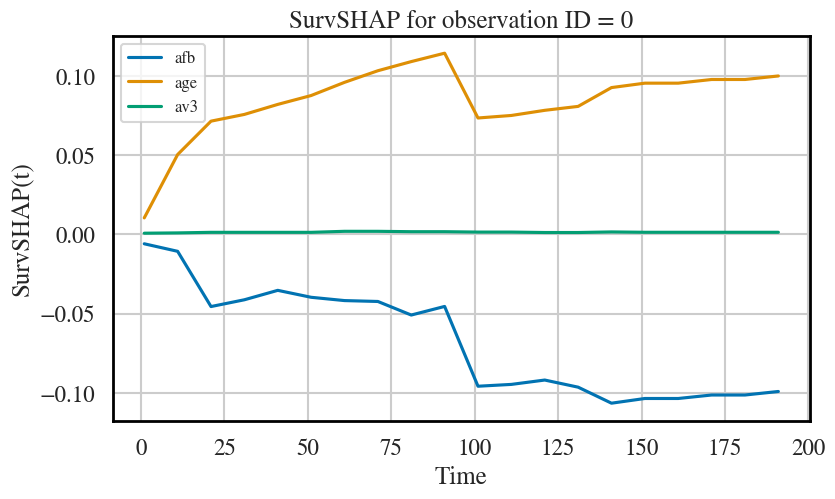

In [51]:
local_explaination.plot_survshap(SurvSHAP_df)

/tmp/ipykernel_93283/3257756621.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


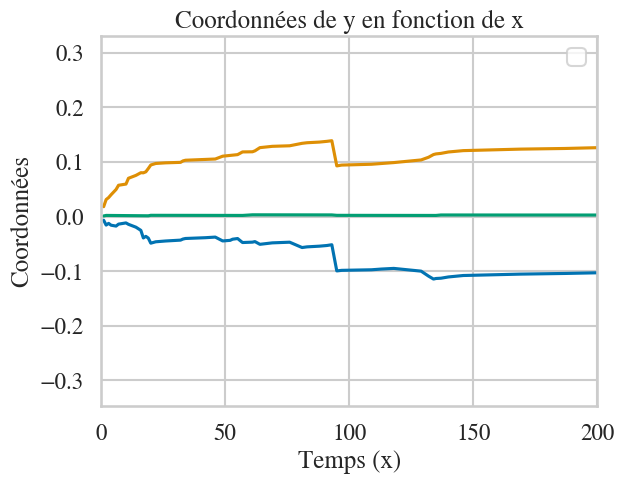

In [53]:
#écris pas éficacement
x=[]
y=[]
for i,t in enumerate(rsf.estimators_[0].unique_times_):
    ex = TreeExplainer(rsf,t=i)
    valeurs = ex.shap_values(X_test.iloc[3, :])[:-1]
    x.append(t)
    y.append(valeurs)

plt.plot(x, y)

# Ajouter des labels et une légende
plt.xlim(0, 200)
plt.xlabel("Temps (x)")
plt.ylabel("Coordonnées")
plt.title("Coordonnées de y en fonction de x")
plt.legend()

# Afficher le graphique
plt.show()
    

# Scalabilité

In [54]:
X, y = load_whas500()
X = X.astype(float)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rsf = RandomSurvivalForest(random_state=42).fit(X_train, y_train)

/tmp/ipykernel_93283/1113273760.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


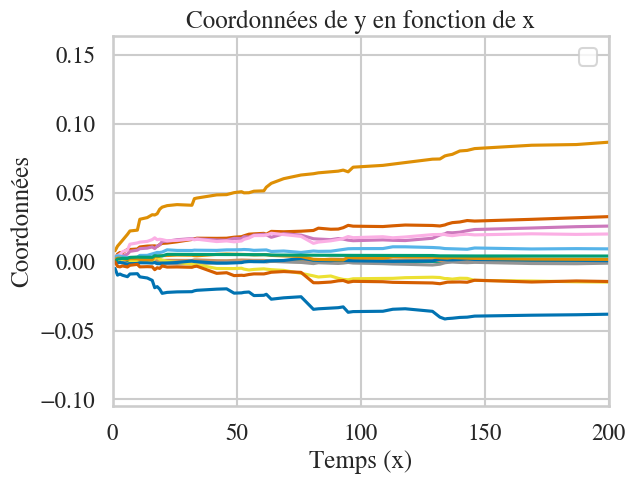

In [58]:
#écris pas éficacement
x=[]
y=[]
for i,t in enumerate(rsf.estimators_[0].unique_times_):
    ex = TreeExplainer(rsf,t=i)
    valeurs = ex.shap_values(X_test.iloc[3, :])[:-1]
    x.append(t)
    y.append(valeurs)

plt.plot(x,y)

# Ajouter des labels et une légende
plt.xlim(0, 200)
plt.xlabel("Temps (x)")
plt.ylabel("Coordonnées")
plt.title("Coordonnées de y en fonction de x")
plt.legend()

# Afficher le graphique
plt.show()

# Junk et tests

In [20]:
print("arbre 0, feuille 0")
print(rsf.estimators_[0].tree_.value[0][:5])
print("arbre 1, feuille 0")
print(rsf.estimators_[1].tree_.value[0][:5])
print("arbre 0, feuille 1")
print(rsf.estimators_[0].tree_.value[1][:5])
print("arbre 1, feuille 1")
print(rsf.estimators_[1].tree_.value[1][:5])

arbre 0, feuille 0
[[0.01       0.99      ]
 [0.03777778 0.9625    ]
 [0.04297258 0.9575    ]
 [0.04819452 0.9525    ]
 [0.06394255 0.9375    ]]
arbre 1, feuille 0
[[0.0275     0.9725    ]
 [0.03521208 0.965     ]
 [0.0429841  0.9575    ]
 [0.04559507 0.955     ]
 [0.05083067 0.95      ]]
arbre 0, feuille 1
[[0.00573066 0.99426934]
 [0.03166726 0.96848138]
 [0.03758442 0.96275072]
 [0.04056061 0.95988539]
 [0.05847106 0.94269341]]
arbre 1, feuille 1
[[0.02056555 0.97943445]
 [0.02843957 0.97172237]
 [0.03637608 0.96401028]
 [0.03904274 0.96143959]
 [0.04439034 0.9562982 ]]


In [21]:
rsf.estimators_[0].unique_times_

array([1.000e+00, 2.000e+00, 3.000e+00, 4.000e+00, 6.000e+00, 7.000e+00,
       1.000e+01, 1.100e+01, 1.400e+01, 1.600e+01, 1.700e+01, 1.800e+01,
       1.900e+01, 2.000e+01, 2.200e+01, 2.600e+01, 3.200e+01, 3.300e+01,
       3.400e+01, 4.200e+01, 4.600e+01, 4.900e+01, 5.200e+01, 5.300e+01,
       5.500e+01, 5.700e+01, 6.100e+01, 6.200e+01, 6.400e+01, 6.900e+01,
       7.600e+01, 8.100e+01, 8.300e+01, 8.800e+01, 9.100e+01, 9.300e+01,
       9.500e+01, 9.700e+01, 1.090e+02, 1.130e+02, 1.180e+02, 1.290e+02,
       1.320e+02, 1.340e+02, 1.350e+02, 1.370e+02, 1.400e+02, 1.430e+02,
       1.460e+02, 1.690e+02, 1.870e+02, 2.000e+02, 2.260e+02, 2.330e+02,
       2.350e+02, 2.590e+02, 2.690e+02, 2.870e+02, 2.890e+02, 2.950e+02,
       2.970e+02, 3.120e+02, 3.130e+02, 3.280e+02, 3.430e+02, 3.450e+02,
       3.540e+02, 3.580e+02, 3.590e+02, 3.680e+02, 3.710e+02, 3.730e+02,
       3.760e+02, 3.820e+02, 3.850e+02, 3.860e+02, 3.900e+02, 3.920e+02,
       3.970e+02, 3.990e+02, 4.030e+02, 4.050e+02, 

In [22]:
X_test.iloc[0,:]

afb     0.0
age    51.0
av3     0.0
Name: 361, dtype: float64

In [23]:
rsf.predict_survival_function( X_test.iloc[:2,:], return_array=False)

array([StepFunction(x=array([1.000e+00, 2.000e+00, 3.000e+00, 4.000e+00, 6.000e+00, 7.000e+00,
              1.000e+01, 1.100e+01, 1.400e+01, 1.600e+01, 1.700e+01, 1.800e+01,
              1.900e+01, 2.000e+01, 2.200e+01, 2.600e+01, 3.200e+01, 3.300e+01,
              3.400e+01, 4.200e+01, 4.600e+01, 4.900e+01, 5.200e+01, 5.300e+01,
              5.500e+01, 5.700e+01, 6.100e+01, 6.200e+01, 6.400e+01, 6.900e+01,
              7.600e+01, 8.100e+01, 8.300e+01, 8.800e+01, 9.100e+01, 9.300e+01,
              9.500e+01, 9.700e+01, 1.090e+02, 1.130e+02, 1.180e+02, 1.290e+02,
              1.320e+02, 1.340e+02, 1.350e+02, 1.370e+02, 1.400e+02, 1.430e+02,
              1.460e+02, 1.690e+02, 1.870e+02, 2.000e+02, 2.260e+02, 2.330e+02,
              2.350e+02, 2.590e+02, 2.690e+02, 2.870e+02, 2.890e+02, 2.950e+02,
              2.970e+02, 3.120e+02, 3.130e+02, 3.280e+02, 3.430e+02, 3.450e+02,
              3.540e+02, 3.580e+02, 3.590e+02, 3.680e+02, 3.710e+02, 3.730e+02,
              3.760e+02, 

In [24]:
rsf.estimators_[0].tree_.predict(X_test.iloc[:2,:].astype(np.float32).to_numpy())

array([[[0.00520833, 0.99479167],
        [0.01567954, 0.984375  ],
        [0.01567954, 0.984375  ],
        ...,
        [0.19599775, 0.82078408],
        [1.19599775, 0.        ],
        [1.19599775, 0.        ]],

       [[0.00636943, 0.99363057],
        [0.05124122, 0.94904459],
        [0.06466404, 0.93630573],
        ...,
        [1.51109332, 0.20858408],
        [1.51109332, 0.20858408],
        [1.51109332, 0.20858408]]])

In [25]:
rsf.estimators_[0].tree_.predict(X_test.iloc[:2,:].astype(np.float32).to_numpy())[...,0]

array([[0.00520833, 0.01567954, 0.01567954, 0.01567954, 0.02097054,
        0.04224714, 0.04224714, 0.0531167 , 0.0531167 , 0.0531167 ,
        0.0531167 , 0.05861121, 0.05861121, 0.05861121, 0.06966093,
        0.06966093, 0.08083412, 0.08083412, 0.08083412, 0.08083412,
        0.08083412, 0.08083412, 0.08083412, 0.08083412, 0.09213355,
        0.09213355, 0.09213355, 0.09213355, 0.09784784, 0.09784784,
        0.09784784, 0.09784784, 0.09784784, 0.09784784, 0.09784784,
        0.09784784, 0.09784784, 0.09784784, 0.09784784, 0.09784784,
        0.09784784, 0.09784784, 0.09784784, 0.09784784, 0.09784784,
        0.09784784, 0.09784784, 0.09784784, 0.09784784, 0.09784784,
        0.09784784, 0.09784784, 0.10359496, 0.10359496, 0.10359496,
        0.10359496, 0.10359496, 0.10359496, 0.10359496, 0.10359496,
        0.10359496, 0.10359496, 0.10359496, 0.10359496, 0.10359496,
        0.10359496, 0.10359496, 0.10359496, 0.10359496, 0.10359496,
        0.10359496, 0.10359496, 0.10359496, 0.10